# Head

In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import sys
sys.path.append('clustering/')

from utils import *

In [26]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm

def load_dataset(file_path, max_rows=None):
    """
    从 JSON 文件加载数据，并转化为 Pandas DataFrame。
    
    Args:
        file_path (str): JSON 文件路径。
        max_rows (int): 加载的最大行数（用于调试或快速测试）。

    Returns:
        pd.DataFrame: 包含数据的 DataFrame。
    """
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for idx, line in enumerate(tqdm(f, total=max_rows, desc="Loading dataset")):
            if max_rows and idx >= max_rows:
                break
            record = json.loads(line.strip())
            data.append(record)
    return pd.DataFrame(data)

def train_random_forest(X_train_tfidf, y_train):
    """
    使用随机森林训练模型。
    
    Args:
        X_train_tfidf: TF-IDF 转换后的训练集特征。
        y_train (pd.Series): 训练集标签。

    Returns:
        model (RandomForestClassifier): 训练好的随机森林模型。
    """
    # 随机森林模型训练
    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_train_tfidf, y_train)
    
    return model

def train_naive_bayes(X_train_tfidf, y_train):
    """
    使用朴素贝叶斯训练模型。
    
    Args:
        X_train_tfidf: TF-IDF 转换后的训练集特征。
        y_train (pd.Series): 训练集标签。

    Returns:
        model (ComplementNB): 训练好的朴素贝叶斯模型。
    """
    # 朴素贝叶斯模型训练
    model = ComplementNB()
    model.fit(X_train_tfidf, y_train)
    
    return model

def evaluate_model(model, X_test_tfidf, y_test):
    """
    评估模型性能。
    
    Args:
        model: 训练好的模型。
        X_test_tfidf: TF-IDF 转换后的测试集特征。
        y_test (pd.Series): 测试集标签。

    Returns:
        dict: 包含性能指标的字典。
    """
    # make prediction
    y_pred = model.predict(X_test_tfidf)
    # print performance metrics
    print(classification_report(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test accuracy：{accuracy:.4f}")

    return y_pred

# Paper-abstract-based classification

In [27]:
import sys
sys.path.append("clustering")

import os
from utils import get_data_dir, prinT
import nltk

# Step 1: Load dataset
dataset_path = os.path.join(get_data_dir(), "2010s","paper_abstract_labels.json")
prinT("Start loading dataset")
df = load_dataset(dataset_path, max_rows=2000000)  # limit rows for quick testing
prinT("Dataset loaded")

# Step 2: split data (keep same X_train, X_test for both labels)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Step 3: construct TF-IDF vectorizer
prinT("Constructing TF-IDF vectorizer...")
vectorizer = TfidfVectorizer(max_features=None, stop_words=nltk.corpus.stopwords.words('english'))
X_train = train_df['abstract']
X_test = test_df['abstract']
X_train_tfidf = vectorizer.fit_transform(X_train)  # only fit on training data
X_test_tfidf = vectorizer.transform(X_test)  # transform on test data
prinT("TF-IDF finished")
# 获取特征数
num_features = len(vectorizer.get_feature_names_out())
print(f"Number of features: {num_features}")

data_dir:  /home/lyuzhuoqi/projects/clustering/data
2024-12-16 14:52:19 -- Start loading dataset


Loading dataset:   0%|                                                              | 0/2000000 [00:00<?, ?it/s]

Loading dataset:  76%|██████████████████████████████████▎          | 1527417/2000000 [00:32<00:10, 47098.05it/s]


2024-12-16 14:52:55 -- Dataset loaded
2024-12-16 14:52:55 -- Constructing TF-IDF vectorizer...
2024-12-16 14:54:48 -- TF-IDF finished
Number of features: 1498135


In [6]:
X_train.values[1]

'We report on the synthesis, characterization, and electrocatalytic performance of ultrathin Pt nanowires with a diameter of less than 2 nm. An acid-wash protocol was employed in order to yield highly exfoliated, crystalline nanowires with a diameter of 1.3 ± 0.4 nm. The electrocatalytic activity of these nanowires toward the oxygen reduction reaction was studied in relation to the activity of both supported and unsupported Pt nanoparticles as well as with previously synthesized Pt nanotubes. Our ultrathin, acid-treated, unsupported nanowires displayed an electrochemical surface area activity of 1.45 mA/cm2, which was nearly 4 times greater than that of analogous, unsupported platinum nanotubes and 7 times greater than that of commercial supported platinum nanoparticles.'

In [28]:
train_df

,PaperID,abstract,Scopus_label,movMF_label,kmeans_label,skm_label,spectral_label,n2v_kmeans_label,cm_kmeans_label
467051,2010332713,Recent developments in instrumentation and fac...,"Biochemistry, Genetics and Molecular Biology",22,17,20,24,20,1
1524977,2078811216,"We report on the synthesis, characterization, ...",Materials Science,23,6,12,19,4,1
749259,2135404031,Objective The aim of this report is to discuss...,Nursing,15,3,13,12,3,1
1378458,1851244949,The Mandarin registers known as lǐyǔ (俚语) have...,Social Sciences,24,19,24,18,9,1
1251736,2312308540,The devastating earthquake (moment magnitude: ...,Agricultural and Biological Sciences,13,8,17,23,2,1
...,...,...,...,...,...,...,...,...,...
259178,1926087805,"Since about three decades, inhibitors of the r...",Medicine,15,7,19,5,3,1
1414414,2031113684,Diet and lifestyle factors have been inconsist...,Medicine,20,4,19,13,12,1
131932,2033999615,The electronic and transport properties of sid...,Physics and Astronomy,23,6,12,19,4,1
671155,2472677174,This article involves a discussion of the prop...,Medicine,19,0,25,3,13,1


In [26]:
# Step 3: train model and evaluate
label_column = 'Scopus_label'

prinT(f"Start training model, using {label_column}")
# model = train_random_forest(X_train_tfidf, train_df[label_column])
model = train_naive_bayes(X_train_tfidf, train_df[label_column])
prinT("Model trained")

2024-12-13 17:03:09 -- Start training model
2024-12-13 17:03:23 -- Model trained


                                              precision    recall  f1-score   support

        Agricultural and Biological Sciences       0.65      0.81      0.72     20509
                         Arts and Humanities       0.71      0.42      0.53      6124
Biochemistry, Genetics and Molecular Biology       0.55      0.47      0.51     18280
         Business, Management and Accounting       0.65      0.30      0.41      3915
                        Chemical Engineering       0.65      0.04      0.08      3615
                                   Chemistry       0.62      0.74      0.68     20611
                            Computer Science       0.59      0.22      0.32      6094
                           Decision Sciences       0.38      0.01      0.02       740
                                   Dentistry       0.79      0.27      0.41      1865
                Earth and Planetary Sciences       0.72      0.68      0.70      8365
         Economics, Econometrics and Finance       0.

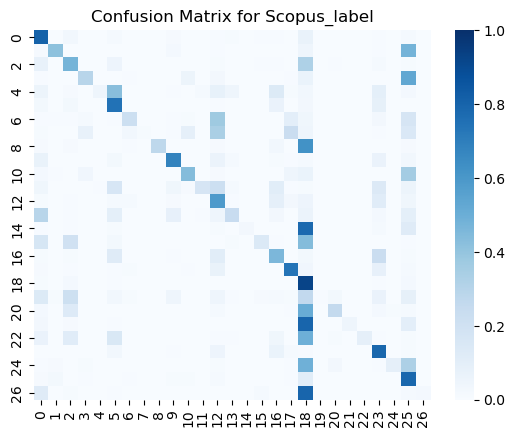

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = evaluate_model(model, X_test_tfidf, test_df[label_column])
cm = confusion_matrix(test_df[label_column], y_pred, normalize='true')
sns.heatmap(cm, annot=False, cmap='Blues', vmin=0, vmax=1)
plt.title(f"Confusion Matrix for {label_column}")
plt.show()

In [21]:
label_column = 'kmeans_label'

prinT(f"Start training model, using {label_column}")
# model = train_random_forest(X_train_tfidf, train_df[label_column])
model = train_naive_bayes(X_train_tfidf, train_df[label_column])
prinT("Model trained")

2024-12-16 14:24:36 -- Start training model, using kmeans_label
2024-12-16 14:24:40 -- Model trained


              precision    recall  f1-score   support

           0       0.62      0.43      0.51      3724
           1       0.58      0.16      0.25      4777
           2       0.57      0.16      0.26      3511
           3       0.77      0.55      0.64      7414
           4       0.67      0.54      0.60     17438
           5       0.54      0.47      0.51      7565
           6       0.67      0.78      0.72     25688
           7       0.57      0.68      0.62     24456
           8       0.68      0.69      0.69     11544
           9       0.61      0.63      0.62     11418
          10       0.60      0.01      0.02      5454
          11       0.69      0.83      0.75     37549
          12       0.70      0.66      0.68     11805
          13       0.48      0.76      0.59      4669
          14       0.63      0.53      0.58     16368
          15       0.69      0.75      0.72     10871
          16       0.66      0.52      0.58      6307
          17       0.60    

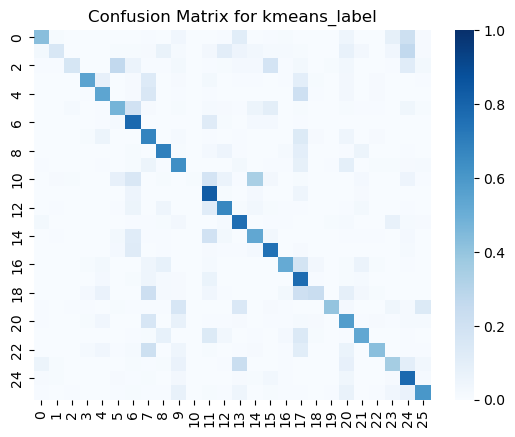

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = evaluate_model(model, X_test_tfidf, test_df[label_column])
cm = confusion_matrix(test_df[label_column], y_pred, normalize='true')
sns.heatmap(cm, annot=False, cmap='Blues', vmin=0, vmax=1)
plt.title(f"Confusion Matrix for {label_column}")
plt.show()

In [ ]:
label_column = 'cm_kmeans_labels'

prinT(f"Start training model, using {label_column}")
# model = train_random_forest(X_train_tfidf, train_df[label_column])
model = train_naive_bayes(X_train_tfidf, train_df[label_column])
prinT("Model trained")

2024-12-16 10:50:15 -- Start training model
2024-12-16 10:50:18 -- Model trained


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        97
           1       0.88      0.95      0.91    262134
           2       0.00      0.00      0.00        54
           3       0.00      0.00      0.00        51
           4       0.00      0.00      0.00        43
           5       0.00      0.00      0.00       331
           6       0.00      0.00      0.00        33
           7       0.00      0.00      0.00      1164
           8       0.00      0.00      0.00        61
           9       0.00      0.00      0.00        63
          10       0.25      0.02      0.03      1061
          11       0.00      0.00      0.00         6
          12       0.00      0.00      0.00        83
          13       0.00      0.00      0.00        15
          14       0.00      0.00      0.00      1386
          15       0.25      0.00      0.00      2910
          16       0.12      0.00      0.01       906
          17       0.00    

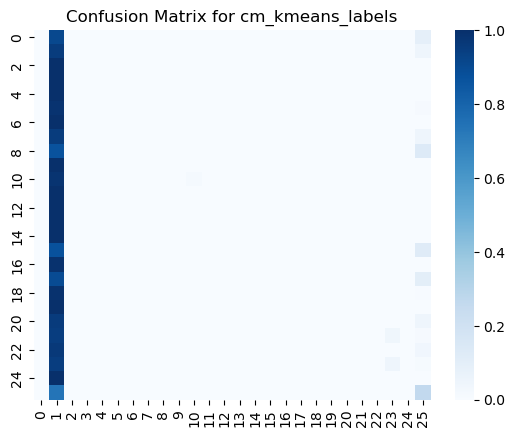

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

evaluate_model(model, X_test_tfidf, test_df[label_column])

y_pred = model.predict(X_test_tfidf)
cm = confusion_matrix(test_df[label_column], y_pred, normalize='true')
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title(f"Confusion Matrix for {label_column}")
plt.show()

In [38]:
df

,PaperID,abstract,Scopus_label,movMF_label,kmeans_label,skm_label,spectral_label,n2v_kmeans_label,cm_kmeans_label
0,2055207790,"Matrix metalloproteinase-13 (MMP-13), referred...",Immunology and Microbiology,22,16,23,23,20,1
1,2055207847,Abstract A technique to generate random fr...,Physics and Astronomy,16,15,0,20,16,1
2,2055207981,Protein phosphorylation is one of the most com...,Chemistry,23,11,12,14,4,25
3,2055208080,Andrew Heaney has been executive director of s...,Social Sciences,2,24,4,2,19,1
4,2055208198,Performance measurement has become an establis...,Social Sciences,2,24,4,6,0,1
...,...,...,...,...,...,...,...,...,...
1527412,2726754945,The relation between home and the workplace is...,Medicine,19,1,25,3,19,1
1527413,2726796044,Resumo da comunicacao apresentado ao XII Congr...,Medicine,15,7,14,7,3,1
1527414,2726821356,Any comprehensive neurobiological depiction of...,Social Sciences,24,19,24,18,13,1
1527415,2726838565,Direct utilization of geothermal energy refers...,Energy,3,5,10,11,15,1


In [42]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import ComplementNB
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
from scipy import interp

# 标签列及对应的方法名称
label_columns = {
    'movMF_label': 'Periodical2Vec+movMF',
    'skm_label': 'Periodical2Vec+Sperical $k$-means',
    'kmeans_label': 'Periodical2Vec+$k$-means',
    'n2v_kmeans_label': 'Node2Vec+$k$-means',
    'cm_kmeans_label': 'Citation Matrix+$k$-means',
    'Scopus_label': 'Scopus'
}

# 数据集 (假设df已经加载)
X = df['abstract'].values
n_splits = 10  # 10折交叉验证

# 初始化保存结果的字典
roc_results = {label: [] for label in label_columns.keys()}

# 初始化交叉验证器
skf = StratifiedKFold(n_splits=n_splits)

# 交叉验证
for fold, (train_index, test_index) in enumerate(skf.split(X, df['movMF_label'])):  # 用任一标签保证分层
    print(f"Processing Fold {fold + 1}/{n_splits}")
    
    # 分割数据
    X_train, X_test = X[train_index], X[test_index]
    
    # TF-IDF 转换
    tfidf = TfidfVectorizer()
    print("Fitting TF-IDF...")
    X_train_tfidf = tfidf.fit_transform(X_train)
    print("Fitting TF-IDF finished")
    X_test_tfidf = tfidf.transform(X_test)
    
    # 针对每个标签列
    for label_column, method_name in label_columns.items():
        print(f"Processing {method_name}")
        
        # 准备数据
        y = label_binarize(df[label_column], classes=sorted(df[label_column].unique()))
        y_train, y_test = y[train_index], y[test_index]
        n_classes = y.shape[1]
        
        # 训练 ComplementNB 模型
        model = ComplementNB()
        classifier = OneVsRestClassifier(model)
        y_score = classifier.fit(X_train_tfidf, y_train).predict_proba(X_test_tfidf)
        
        # 计算 ROC 曲线和 AUC
        fpr = dict()
        tpr = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        
        # 宏平均 ROC 曲线
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= n_classes
        macro_auc = auc(all_fpr, mean_tpr)
        
        # 保存每折结果
        roc_results[label_column].append((all_fpr, mean_tpr, macro_auc))


Processing Fold 1/10
Fitting TF-IDF...
Fitting TF-IDF finished
Processing Periodical2Vec+movMF
Processing Periodical2Vec+Sperical $k$-means
Processing Periodical2Vec+$k$-means
Processing Node2Vec+$k$-means
Processing Citation Matrix+$k$-means
Processing Scopus
Processing Fold 2/10
Fitting TF-IDF...
Fitting TF-IDF finished
Processing Periodical2Vec+movMF
Processing Periodical2Vec+Sperical $k$-means
Processing Periodical2Vec+$k$-means
Processing Node2Vec+$k$-means
Processing Citation Matrix+$k$-means
Processing Scopus
Processing Fold 3/10
Fitting TF-IDF...
Fitting TF-IDF finished
Processing Periodical2Vec+movMF
Processing Periodical2Vec+Sperical $k$-means
Processing Periodical2Vec+$k$-means
Processing Node2Vec+$k$-means
Processing Citation Matrix+$k$-means
Processing Scopus
Processing Fold 4/10
Fitting TF-IDF...
Fitting TF-IDF finished
Processing Periodical2Vec+movMF
Processing Periodical2Vec+Sperical $k$-means
Processing Periodical2Vec+$k$-means
Processing Node2Vec+$k$-means
Processing 

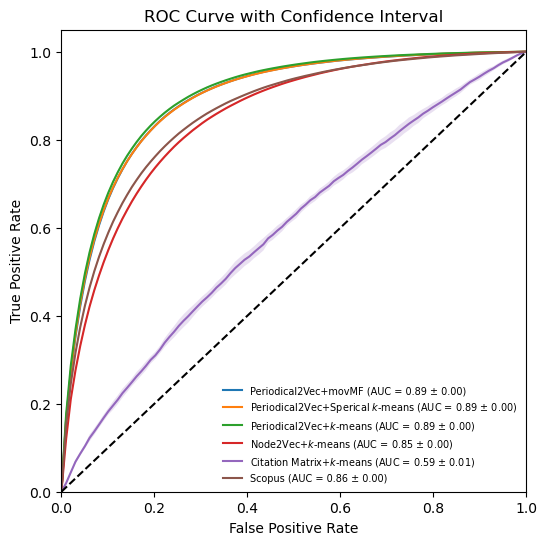

In [55]:
from scipy.stats import sem, t
# 汇总每个标签的结果并绘制 ROC 曲线
plt.figure(figsize=(6, 6))

for label_column, method_name in label_columns.items():
    fpr_list = [result[0] for result in roc_results[label_column]]
    tpr_list = [result[1] for result in roc_results[label_column]]
    auc_list = [result[2] for result in roc_results[label_column]]
    
    # 计算平均曲线
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(fpr_list, tpr_list)], axis=0)
    
    # 计算置信区间
    confidence = 0.95
    t_value = t.ppf((1 + confidence) / 2, df=n_splits - 1)  # t 分布
    std_error = sem([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(fpr_list, tpr_list)], axis=0)
    ci = t_value * std_error  # 置信区间
    
    mean_auc = np.mean(auc_list)
    std_auc = np.std(auc_list)
    
    # 绘制 ROC 曲线
    plt.plot(
        mean_fpr, mean_tpr,
        label=f'{method_name} (AUC = {mean_auc:.2f} ± {std_auc:.2f})'
    )
    plt.fill_between(
        mean_fpr,
        mean_tpr - ci,
        mean_tpr + ci,
        alpha=0.2,
    )

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Confidence Interval')
plt.legend(loc="lower right", fontsize=7, frameon=False)
plt.show()

# Journal-title-based classification

In [60]:
import os
import pandas as pd

cluster_df = pd.read_parquet(os.path.join(get_data_dir(), "2010s", "cluster_df.parquet"))
venue_df = pd.read_parquet(os.path.join(get_data_dir(),"MAG_venue.parquet"))
cluster_df = pd.merge(cluster_df, venue_df['OriginalVenue'], left_index=True, right_index=True)
cluster_df

data_dir:  /home/lyuzhuoqi/projects/clustering/data
data_dir:  /home/lyuzhuoqi/projects/clustering/data


,Scopus_label,movMF_label,movMF_distance,x_val,y_val,kmeans_label,kmeans_distance,skm_label,skm_distance,spectral_label,n2v_kmeans_label,OriginalVenue
VID,,,,,,,,,,,,
202381698,Multidisciplinary,22,0.445886,-67.928200,15.572327,17,0.628846,20,0.444711,24,3,PLOS ONE
137773608,Multidisciplinary,22,0.590942,-68.405334,-55.633186,17,0.735654,20,0.559494,24,20,Nature
125754415,Multidisciplinary,22,0.574571,-68.448853,-55.613579,17,0.705024,20,0.550081,24,20,Proceedings of the National Academy of Science...
3880285,Multidisciplinary,23,0.618842,-68.407288,-55.634430,8,0.724859,17,0.610582,24,20,Science
111155417,Chemistry,23,0.220853,-54.506985,-61.217068,11,0.495787,12,0.198758,14,4,Journal of the American Chemical Society
...,...,...,...,...,...,...,...,...,...,...,...,...
2764485818,Medicine,21,0.268070,-28.969574,34.819569,18,0.542531,14,0.251015,8,18,The internet journal of the third world medicine
83454320,Arts and Humanities,25,0.034777,78.609909,31.736822,13,0.251599,3,0.056642,21,5,Publications of The English Goethe Society
16507453,Arts and Humanities,6,0.113656,89.206772,17.625090,13,0.307089,3,0.128660,21,5,Peritia


In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import nltk

# Step 2: split data (keep same X_train, X_test for both labels)
train_df, test_df = train_test_split(cluster_df, test_size=0.2, random_state=42)

# Step 3: construct TF-IDF vectorizer
prinT("Constructing TF-IDF vectorizer...")
vectorizer = TfidfVectorizer(max_features=None, stop_words=nltk.corpus.stopwords.words('english'))
X_train = train_df['OriginalVenue']
X_test = test_df['OriginalVenue']
X_train_tfidf = vectorizer.fit_transform(X_train)  # only fit on training data
X_test_tfidf = vectorizer.transform(X_test)  # transform on test data
prinT("TF-IDF finished")
# 获取特征数
num_features = len(vectorizer.get_feature_names_out())
print(f"Number of features: {num_features}")

2024-12-13 16:45:51 -- Constructing TF-IDF vectorizer...
2024-12-13 16:45:52 -- TF-IDF finished
Number of features: 7500


In [49]:
# Step 3: train model and evaluate
label_column = 'Scopus_label'

prinT("Start training model")
# model = train_random_forest(X_train_tfidf, train_df[label_column])
model = train_naive_bayes(X_train_tfidf, train_df[label_column])
prinT("Model trained")

2024-12-13 16:34:17 -- Start training model
2024-12-13 16:34:17 -- Model trained


                                              precision    recall  f1-score   support

        Agricultural and Biological Sciences       0.48      0.81      0.60       290
                         Arts and Humanities       0.70      0.56      0.62       314
Biochemistry, Genetics and Molecular Biology       0.62      0.47      0.54       139
         Business, Management and Accounting       0.69      0.73      0.71       130
                        Chemical Engineering       0.58      0.27      0.37        26
                                   Chemistry       0.57      0.58      0.58        74
                            Computer Science       0.67      0.73      0.70       136
                           Decision Sciences       0.62      0.29      0.40        17
                                   Dentistry       0.92      0.64      0.75        36
                Earth and Planetary Sciences       0.66      0.61      0.63       104
         Economics, Econometrics and Finance       0.

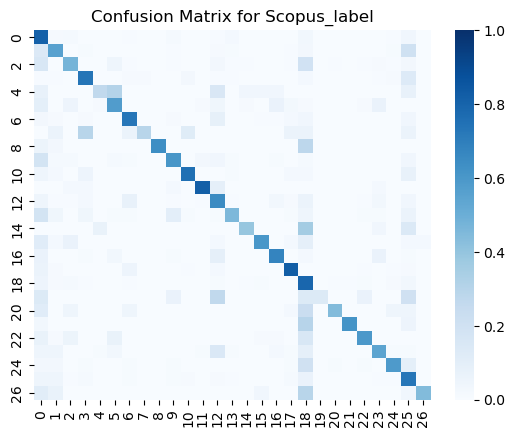

In [50]:
evaluate_model(model, X_test_tfidf, test_df[label_column])

y_pred = model.predict(X_test_tfidf)
cm = confusion_matrix(test_df[label_column], y_pred, normalize='true')
sns.heatmap(cm, annot=False, cmap='Blues', vmin=0, vmax=1)
plt.title(f"Confusion Matrix for {label_column}")
plt.show()

In [47]:
label_column = 'movMF_label'

prinT("Start training model")
# model = train_random_forest(X_train_tfidf, train_df[label_column])
model = train_naive_bayes(X_train_tfidf, train_df[label_column])
prinT("Model trained")

2024-12-13 16:34:08 -- Start training model
2024-12-13 16:34:08 -- Model trained


              precision    recall  f1-score   support

           0       0.38      0.71      0.50       239
           1       0.55      0.43      0.48       141
           2       0.46      0.68      0.55       154
           3       0.62      0.62      0.62        82
           4       0.78      0.60      0.67        52
           5       0.74      0.58      0.65       157
           6       0.67      0.44      0.53        41
           7       0.94      0.75      0.84        44
           8       0.77      0.62      0.68       130
           9       0.00      0.00      0.00         5
          10       0.70      0.65      0.68        80
          11       0.68      0.70      0.69       162
          12       0.65      0.72      0.68       307
          13       0.65      0.65      0.65       144
          14       0.52      0.36      0.42        39
          15       0.62      0.59      0.60       288
          16       0.70      0.80      0.75       131
          17       0.68    

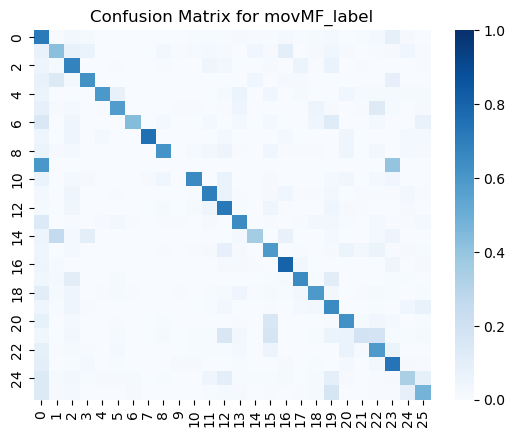

In [48]:
evaluate_model(model, X_test_tfidf, test_df[label_column])

y_pred = model.predict(X_test_tfidf)
cm = confusion_matrix(test_df[label_column], y_pred, normalize='true')
sns.heatmap(cm, annot=False, cmap='Blues', vmin=0, vmax=1)
plt.title(f"Confusion Matrix for {label_column}")
plt.show()

In [43]:
label_column = 'n2v_kmeans_label'

prinT("Start training model")
# model = train_random_forest(X_train_tfidf, train_df[label_column])
model = train_naive_bayes(X_train_tfidf, train_df[label_column])
prinT("Model trained")

2024-12-13 16:33:27 -- Start training model
2024-12-13 16:33:27 -- Model trained


              precision    recall  f1-score   support

           0       0.12      0.18      0.14       228
           1       0.37      0.46      0.41       127
           2       0.47      0.50      0.48       152
           3       0.26      0.31      0.29       267
           4       0.35      0.38      0.36        84
           5       0.09      0.05      0.07        37
           6       0.11      0.05      0.07        40
           7       0.28      0.33      0.30       168
           8       0.47      0.42      0.44        57
           9       0.46      0.59      0.52       150
          10       0.27      0.18      0.22       341
          11       0.23      0.15      0.18        67
          12       0.38      0.31      0.34        68
          13       0.29      0.22      0.25       339
          14       0.27      0.20      0.23       336
          15       0.21      0.27      0.24       124
          16       0.38      0.51      0.44        49
          17       0.22    

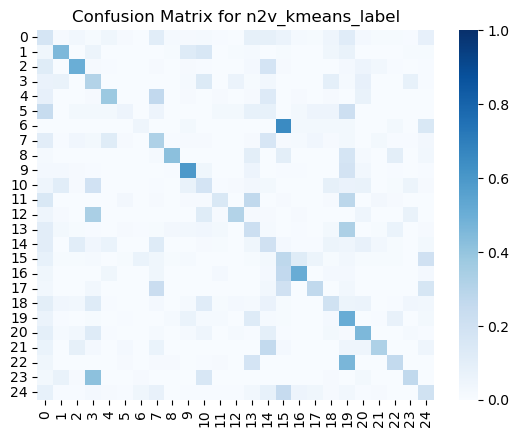

In [44]:
evaluate_model(model, X_test_tfidf, test_df[label_column])

y_pred = model.predict(X_test_tfidf)
cm = confusion_matrix(test_df[label_column], y_pred, normalize='true')
sns.heatmap(cm, annot=False, cmap='Blues', vmin=0, vmax=1)
plt.title(f"Confusion Matrix for {label_column}")
plt.show()